In [44]:
import pandas as pd
import numpy as np

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings('ignore')

In [45]:
data_train = pd.read_csv('data/mnist/mnist_train.csv')
data_test = pd.read_csv('data/mnist/mnist_test.csv')

N_train = 6000
n_train = N_train/len(data_train)
N_test = 1000
n_test = N_test/len(data_test)

data_train = data_train.sample(frac=n_train, random_state=9)
data_test = data_test.sample(frac=n_test, random_state=9)

X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(6000, 784)

In [46]:
import torch

# Set the hyperparameters for data creation
NUM_CLASSES = 10
NUM_FEATURES = 28*28
RANDOM_SEED = 9


# 2. Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)
print(X_train[:5], y_train[:5])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 8, 9, 2, 9])


In [47]:
from torch import nn

class Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = Model(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=5)
model

Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=784, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [48]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1)

In [49]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

for epoch in range(epochs+1):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % (epochs/10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.31639, Acc: 13.37% | Test Loss: 2.32235, Test Acc: 11.20%
Epoch: 100 | Loss: 1.47987, Acc: 42.40% | Test Loss: 1.48503, Test Acc: 41.00%
Epoch: 200 | Loss: 0.92740, Acc: 67.03% | Test Loss: 0.96308, Test Acc: 66.40%
Epoch: 300 | Loss: 0.65730, Acc: 79.62% | Test Loss: 0.73356, Test Acc: 77.50%
Epoch: 400 | Loss: 0.47308, Acc: 86.52% | Test Loss: 0.61067, Test Acc: 81.60%
Epoch: 500 | Loss: 0.39576, Acc: 88.87% | Test Loss: 0.58499, Test Acc: 82.80%
Epoch: 600 | Loss: 0.35222, Acc: 90.40% | Test Loss: 0.60198, Test Acc: 82.00%
Epoch: 700 | Loss: 0.32537, Acc: 91.18% | Test Loss: 0.62684, Test Acc: 82.20%
Epoch: 800 | Loss: 0.30538, Acc: 91.72% | Test Loss: 0.64752, Test Acc: 82.10%
Epoch: 900 | Loss: 0.28733, Acc: 92.32% | Test Loss: 0.66940, Test Acc: 82.40%
Epoch: 1000 | Loss: 0.27273, Acc: 92.87% | Test Loss: 0.69480, Test Acc: 82.10%


In [50]:
print(X_test.shape)
print(model.linear_layer_stack[0].weight.shape)
first_layer = np.array(model.linear_layer_stack[1](torch.tensor(np.dot(X_test, model.linear_layer_stack[0].weight.detach().numpy().T))))
print(first_layer.shape)

torch.Size([1000, 784])
torch.Size([5, 784])
(1000, 5)


In [51]:
new_data = pd.DataFrame(first_layer)
new_data.columns = ['Neurone_1', 'Neurone_2', 'Neurone_3', 'Neurone_4', 'Neurone_5']
display(new_data.head())
print(new_data.shape)

,Neurone_1,Neurone_2,Neurone_3,Neurone_4,Neurone_5
0,3.058975,0.000000,3.854586,0.000000,4.675099
1,0.000000,0.000000,0.000000,2.032344,0.000000
2,3.987611,0.000000,4.830905,0.000000,2.823363
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,8.241152,3.284517,0.000000,0.175566


(1000, 5)


In [52]:
def image(ligne):
    return np.array(ligne).reshape(28,28)

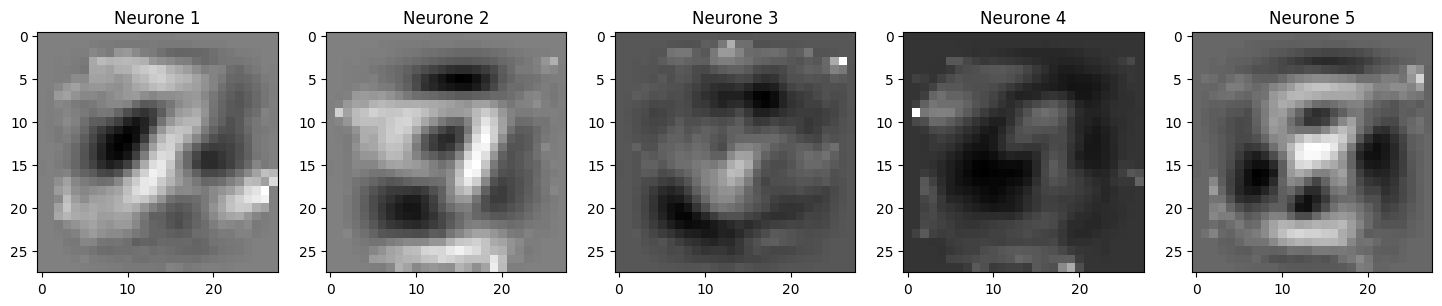

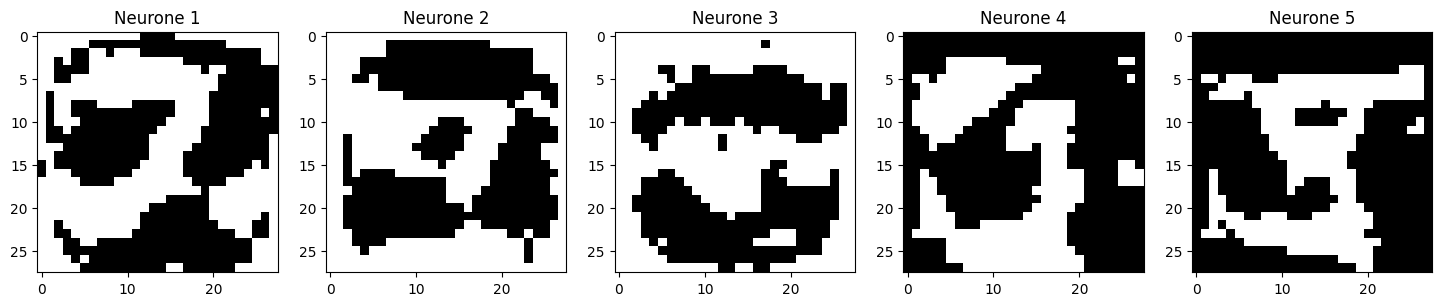

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 5.5))
columns = 5
rows = 1

for i in range(columns*rows):
    a = np.array(X_test.T)
    b = np.array(new_data.iloc[:,i])
    c = np.dot(a,b)/sum(b)
    m = np.mean(c)
    mon_image = image(c)
    fig.add_subplot(rows, columns, i+1)
    plt.title('Neurone '+str(i+1))
    plt.imshow(mon_image, cmap='gray')
plt.show()

fig1 = plt.figure(figsize=(18, 5.5))
for i in range(columns*rows):
    a = np.array(X_test.T)
    b = np.array(new_data.iloc[:,i])
    c = np.dot(a,b)/sum(b)
    m = np.mean(c)
    l = []
    for j in range(len(c)):
        if c[j] > m:
            l.append(255)
        else:
            l.append(0)
    mon_image = image(l)
    fig1.add_subplot(rows, columns, i+1)
    plt.title('Neurone '+str(i+1))
    plt.imshow(mon_image, cmap='gray')
plt.show()

In [54]:
class New_model():
    def __init__(self):
        pass
    def predict(X):
        retour = np.dot(X, model.linear_layer_stack[2].weight.detach().numpy().T)
        retour = np.array(model.linear_layer_stack[3](torch.tensor(retour)))
        retour = np.dot(retour, model.linear_layer_stack[4].weight.detach().numpy().T)
        retour = torch.softmax(torch.tensor(retour), dim=1).argmax(dim=1)
        return np.array(retour)

In [55]:
print(f'Précision du modèle : {round(list(New_model.predict(first_layer)-np.array(y_test)).count(0)/len(y_test)*100,6)}%')

Précision du modèle : 74.7%


In [56]:
X = pd.DataFrame(new_data)
y = pd.Series(y_test)
new_model = New_model

In [57]:
import antakia
explain = antakia.Xplainer(X = X, Y = y, model = new_model)

display(explain.interface(explanation = "SHAP"))

Layout(children=[Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\t2\x00\x00\n\xd5\x08\x06\x00\x00\x0…